In [41]:
display(HTML("<style>.rendered_html.text_cell_render {max-width:500px; }</style>"));

HTML{String}("<style>.rendered_html.text_cell_render {max-width:500px; }</style>")

In [39]:
using Markdown
d = @doc logsumexp;
Markdown.parse("""
    test

a
""")


```
test
```

a


# 2dp3 Sensor Gen Distribution - CUDA accelerated

In [2]:
push!(LOAD_PATH, "../src");
include("../src/pose.jl")
include("src/csail_data.jl")
include("../src/cuda_raycaster_point_cloud_b.jl");

"""
    zs_ = cast_cu(ps_::CuArray, ys_::CuArray; fov=2π, zmax=Inf, cell_rad=0.01)

Computes depth measurements `zs_` with respect to a matrix of poses `ps_`
and a point cloud matrix `ys_` ...
"""
function cast_cu(ps_::CuArray, ys_::CuArray; fov=2π, zmax=Inf, cell_rad=0.05)
    zs_ = zmax*CUDA.ones(size(ps_, 1), 361)
    cast_cu!(zs_, ys_, ps_; fov=fov, cell_rad=cell_rad)
    return zs_
end;

Loading `../data/mit-csail.json` ...

	_zs 	Vector{Vector{Float64}}
	_zs_inf 	Vector{Vector{Float64}}
	_as 	Vector{Float64}
	_zmax 	Float64
	_ys 	Vector{Vector{Vector{Float64}}}
	_ys_inf 	Vector{Vector{Vector{Float64}}}
	_num_a 	Int64
	_xs 	Vector{Vector{Float64}}
	_hds 	Vector{Float64}
	_ps 	Vector{Pose}
	_dxs 	Vector{Vector{Float64}}
	_dhds 	Vector{Float64}
	_us 	Vector{Control}
	_T 	Int64


We only use the above includes for visualization purposes. The actual module starts here. 

In [3]:
#nbx --fname=src/sensor_distribution.jl
push!(LOAD_PATH, "../src");
push!(LOAD_PATH, ENV["probcomp"]*"/Gen-Distribution-Zoo/src");
using CUDA
using Gen
using MyUtils # ../src
using GenDistributionZoo: diagnormal 
using Test

In [4]:
#nbx
"""
    log_p = gaussian_logpdf(x, mu, sig)

Benchmarked in `33 - CUDA Accelerated Gen Distributions`.
"""
function gaussian_logpdf(x, mu, sig)
    d = (x .- mu).^2 ./ sig.^2
    log_p = - log.(sig) .- log(sqrt(2π)) .- 1/2 * d
    return log_p
end;

Just a quick reality check that we did not mess anything up in the definition above.

In [5]:
@testset "Gaussian reality check" begin 
for i=1:100
    x   = rand()
    mu  = rand()
    sig = rand()
    
    @test isapprox(logpdf(normal,  x, mu, sig), 
                   gaussian_logpdf(x, mu, sig))
    @test gaussian_logpdf(x, Inf, 1) == -Inf
end 
end;

Test Summary:          | Pass  Total  Time
Gaussian reality check |  200    200  0.3s


In [6]:
#nbx
"""
    logsumexp(x; dims)

Logsumexp along dimenstions.
"""
function Gen.logsumexp(x; dims)
    c = maximum(x)
    return c .+ log.(sum(exp.(x .- c), dims=dims))
end;

## Sliding windows

In [10]:
#nbx 
"""
    griddims = cuda_grid(datadims::Tuple{Vararg{Int}},
                         blockdims::Tuple{Vararg{Int}})

Given data dimensions `datadims` and number of threads
in each dimension `blockdims` returns the respective
grid dimensions `griddims` such that

    griddims[i] = ceil(Int, datadims[i]/blockdims[i])

"""
function cuda_grid(datadims::Tuple{Vararg{Int}}, blockdims::Tuple{Vararg{Int}})
    griddims = ceil.(Int, datadims./blockdims)
    return griddims
end

# Todo: handle wrap around and padding smarter?
"""
    slw_kernel!(x, y, w, pad, fill_val)

CUDA kernel to compute sliding windows.
Takes CuArrays of shape `(k,n)` and `(k,n,2w+1)`...
"""
function slw_kernel!(x, y, w::Int, wrap::Bool, fill::Bool, fill_val::Float64)
    
    m = 2*w + 1
    n = size(x,2)

    # Make sure the arrays are 
    # of the right shape
    @assert ndims(x)  == 2
    @assert ndims(y)  == ndims(x) + 1
    @assert size(x,1) == size(y,1)
    @assert size(x,2) == size(y,2)
    @assert size(y,3) == m
    
    # Thread id's
    ix = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    iy = (blockIdx().y - 1) * blockDim().y + threadIdx().y
    iz = (blockIdx().z - 1) * blockDim().z + threadIdx().z
    sx = gridDim().x * blockDim().x
    sy = gridDim().y * blockDim().y
    sz = gridDim().z * blockDim().z
        
    for j_pose = ix:sx:size(y,1), j_obs = iy:sy:size(y,2), j_mix = iz:sz:size(y,3)
        # Transform mixture index in `1:m` 
        # to offsets in `-w:w`
        offset = j_mix-1-w
        
        j = j_obs + offset
        if wrap
            j = mod(j - 1 , n) + 1
            val = x[j_pose, j]
        else
            if 1 <= j <= n
                val = x[j_pose, j]
            else
                if fill
                    val = fill_val
                else
                    j = max(min(j,n),1)
                    val = x[j_pose, j]
                end
            end
        end
        
        # Fill entries of `y`
        @inbounds y[j_pose, j_obs, j_mix] = val
    end
    return
end

"""
```julia
    y = slw_cu!(x::CuArray, w::Int; blockdims=(8,8,4), wrap=false, pad_val=nothing)
```
CUDA-accelerated function computing sliding windows. 
Takes a CuArray of shape `(k,n)` and returns a CuArray
of shape `(k,n,m)`, where `m = 2w+1`....
"""
function slw_cu!(x::CuArray, w::Int; blockdims=(8,8,4), wrap=false, fill=false, fill_val=Inf)
    
    k = size(x, 1)
    n = size(x, 2)
    m = 2*w+1
    
    y = CUDA.ones(k,n,m)
    
    # `cuda_grid` defined in reaycaster file, I also put it in utils
    griddims = cuda_grid((k,n,m), blockdims)
    CUDA.@sync begin
        @cuda threads=blockdims blocks=griddims slw_kernel!(x, y, w, wrap, fill, fill_val)
    end
    
    return y
end;

In [11]:
k = 10
n = 7
w = 2

x  = stack(fill(collect(1.0:n), k))
x_ = CuArray(x)

y_ = slw_cu!(x_, w, blockdims=(8,8,4), wrap=false, fill=true, fill_val=Inf)
y  = Array(y_);
y[1,:,:]

7×5 Matrix{Float32}:
 Inf   Inf   1.0   2.0   3.0
 Inf    1.0  2.0   3.0   4.0
  1.0   2.0  3.0   4.0   5.0
  2.0   3.0  4.0   5.0   6.0
  3.0   4.0  5.0   6.0   7.0
  4.0   5.0  6.0   7.0  Inf
  5.0   6.0  7.0  Inf   Inf

## 2D Sensor Distribution (for point clouds)

### Mixture components

In [8]:
#nbx
MyUtils.polar_inv(z::CuArray, a::CuArray) = cat(z.*cos.(a), z.*sin.(a), dims=ndims(a)+1);

In [9]:
#nbx
"""
    ys_tilde_ = get_ys_tilde_cu(zs_::CuArray, w::Int)    

Computes the 2d mixture components for the "2dp3" likelihood from 
    depth measurements `zs_` along angles `as_`, and with a filter radius of `w`.
    
    Arguments:
            zs_: Range measurements `(k,n)`
            as_: Angles of measuremnts `(n,)`
            w:   Filter window radius
    
    Returns:
        CuArray of shape `(k, n, 2w+1, 2)`
"""
function get_ys_tilde_cu(zs_::CuArray, as_::CuArray, w::Int; wrap=false, fill=false, fill_val=0.0)   

    zs_tilde_ = slw_cu!(zs_, w; blockdims=(8,8,4), wrap=wrap)
    as_tilde_ = slw_cu!(reshape(as_,1,:), w; blockdims=(8,8,4), wrap=wrap)
    ys_tilde_ = polar_inv(zs_tilde_, as_tilde_)
    
    return ys_tilde_
end;

In [10]:
#nbx
# Same as above but want to switch 
# to different name going forward
"""
```julia
    mcs_::CuArray = get_2d_mixture_components(zs_::CuArray, as_::CuArray, w::Int; 
                                     wrap=false, fill=true, fill_val=Inf)
```
Computes the 2d mixture components for the "2dp3" likelihood from 
depth measurements `zs_` along angles `as_`, and with a filter radius of `w`.

Arguments:
     zs_: Range measurements `(k,n)`
     as_: Angles of measuremnts `(n,)`
     w:   Filter window radius

Returns:
    CuArray of shape `(k, n, 2w+1, 2)`
"""
function get_2d_mixture_components(zs_::CuArray, as_::CuArray, w::Int; wrap=false, fill=true, fill_val=Inf)
    zs_tilde_ = slw_cu!(zs_, w; blockdims=(8,8,4),  wrap=wrap, fill=fill, fill_val=fill_val)
    as_tilde_ = slw_cu!(reshape(as_,1,:), w; blockdims=(8,8,4), wrap=false, fill=true, fill_val=Inf)
    ys_tilde_ = polar_inv(zs_tilde_, as_tilde_)
    
    return ys_tilde_
end

get_2d_mixture_components

### Likelihood

In [11]:
#nbx
"""
```julia
    log_ps, ptw = sensor_smc_logpdf_cu(x, ys, sig, outlier, outlier_vol=1.0; return_pointwise=false)
```
Evaluates an observation `x` under the 2dp3 likelihood with 
a family of mixture components `ys` and parameters `sig`, `outlier`, and `outlier_vol`.
 
Arguments:
    x:  Observation point cloud `(n,2)`
    ys: Family of mixture components `(k,n,m,2)`
    ...

Returns:
    log_ps: Logprobs `(k,)`
    ptw:    Logprobs of each observation point `(k,n)`
"""
function sensor_smc_logpdf_cu(x, y, sig, outlier, outlier_vol=1.0; return_pointwise=false)
    @assert size(x,1) == size(y,2)

    n = size(y,2)
    m = size(y,3)
    x = reshape(x, 1, n, 1, 2)
    
    # Line by line...
    # 1. Compute 1D Gaussians (n,m,2)
    # 2. Convert to 2D gausians (n,m)
    # 3. Convert to mixture of m 2D gausians `GM` (n,)
    # 4. Convert to mixture of `GM` and `anywhere` (n,)
    log_p = gaussian_logpdf(x, y, sig)
    log_p = sum(log_p, dims=4)
    log_p = logsumexp(log_p .- log(m), dims=3)
    log_p = log.((1 .- outlier).*exp.(log_p) .+ outlier./outlier_vol)
    
    # If we don't need pointwise logprobs
    # we can save us the time and space to copy
    pointwise = nothing
    if return_pointwise
        pointwise = dropdims(log_p, dims=(3,4))
    end

    # Convert to Product of mixtures 
    log_p = sum(log_p, dims=2)
    log_p  = dropdims(log_p, dims=(2,3,4))

    return log_p, pointwise
end;


In [25]:
#nbx
@doc raw"""
```julia
    log_ps, ptw = sensor_logpdf(x, ys, sig, outlier, outlier_vol=1.0; return_pointwise=false)
```
Evaluates an observation `x` under the 2dp3 likelihood with 
a family of mixture components `ys` and parameters `sig`, `outlier`, and `outlier_vol`.

Arguments:
 - x:  Observation point cloud `(n,2)`
 - ys: Family of mixture components `(k,n,m,2)`
 - ...

Returns:
 - log_ps: Logprobs `(k,)`
 - ptw:    Logprobs of each observation point `(k,n)`
"""
sensor_logpdf(x, y, sig, outlier, outlier_vol=1.0; return_pointwise=false) = sensor_smc_logpdf_cu(x, y, sig, outlier, outlier_vol; return_pointwise=return_pointwise)

sensor_logpdf

In [26]:
x   = rand(10,2)
ys  = rand(7,10,3,2)

x_  = CuArray(x)
ys_ = CuArray(ys)

sig         = 1.0
outlier     = 0.1
outlier_vol = 10.0

log_ps , ptw  = sensor_logpdf(x , ys , sig, outlier, outlier_vol; return_pointwise=true)
log_ps_, ptw_ = sensor_logpdf(x_, ys_, sig, outlier, outlier_vol; return_pointwise=true)

@assert isapprox(log_ps, Array(log_ps_))

In [27]:
#nbx
struct SensorDistribution_CUDA <: Distribution{Vector{Vector{Float64}}} 
end

"""
    sensordist_cu(mcs_::CuArray, sig, outlier, outlier_vol=1.0)
"""
const sensordist_cu = SensorDistribution_CUDA()

function Gen.logpdf(::SensorDistribution_CUDA, x, y_tilde_::CuArray, sig, outlier, outlier_vol=1.0)
    
    n = size(y_tilde_, 1)
    m = size(y_tilde_, 2)
    
    x_        = CuArray(stack(x))
    ys_tilde_ = reshape(y_tilde_, 1, n, m, 2) 
    
    log_p, = sensor_logpdf(x_, ys_tilde_, sig, outlier, outlier_vol) # CuArray of length 1
    return CUDA.@allowscalar log_p[1]
end

function Gen.random(::SensorDistribution_CUDA, y_tilde_::CuArray, sig, outlier, outlier_vol=1.0)
    n = size(y_tilde_,1)
    m = size(y_tilde_,2)
    
    # Sample an observation point cloud `x`
    x = Vector{Float64}[]
    for i=1:n
        if bernoulli(outlier)
            # Todo: Change that to a uniform distribution, e.g. over a  
            #       circular area with radius `zmax`.
            x_i = [Inf;Inf]
        else
            j   = rand(1:m)
            y   = Array(y_tilde_[i,j,:])
            x_i = diagnormal(y, [sig;sig])

        end
        push!(x, x_i)
    end
    
    return x
end

(D::SensorDistribution_CUDA)(args...)             = Gen.random(D, args...)
Gen.has_output_grad(::SensorDistribution_CUDA)    = false
Gen.has_argument_grads(::SensorDistribution_CUDA) = (false, false);

In [15]:
?sensor_logpdf

search: sensor_logpdf sensor_smc_logpdf_cu



```julia
    log_ps, ptw = sensor_logpdf(x, ys, sig, outlier, outlier_vol=1.0; return_pointwise=false)
```

Evaluates an observation `x` under the 2dp3 likelihood with  a family of mixture components `ys` and parameters `sig`, `outlier`, and `outlier_vol`.

Arguments:

  * x:  Observation point cloud `(n,2)`
  * ys: Family of mixture components `(k,n,m,2)`
  * ...

Returns:

  * log_ps: Logprobs `(k,)`
  * ptw:    Logprobs of each observation point `(k,n)`


In [35]:
ys  = rand(10,3,2)
ys_ = CuArray(ys)

sig         = 1.0
outlier     = 0.1
outlier_vol = 10.0
args = (ys_, sig, outlier, outlier_vol)
x = sensordist_cu(args...)
logpdf(sensordist_cu, x, args...)

-26.968759621354728

## 1D Sensor Distribution

### 1D Mixture

In [ ]:
"""
```julia
    cs_, ws_ = get_2d_mixture_components(zs_::CuArray, as_::CuArray, w::Int; 
                                     wrap=false, fill=true, fill_val=Inf)
```
Computes the 1d mixture components and their weights for the "2dp3" likelihood 
(or rather for the induced line distributions) from depth measurements `zs_` 
along angles `as_`, and with a filter radius of `w`.

Arguments:
     zs_: Range measurements `(k,n)`
     as_: Angles of measuremnts `(n,)`
     w:   Filter window radius

Returns:
    cs_: 1d mixture components `(k, n, 2w+1)`
    ws_: 1d mixture weights `(k, n, 2w+1)`
"""
function get_1d_mixture_components(zs_, as_, w, sig; wrap=false, fill=true, fill_val=Inf)
    zs_tilde_  = slw_cu!(zs_, w; blockdims=(8,8,4), wrap=wrap, fill=fill, fill_val=fill_val)
    as_tilde_  = slw_cu!(reshape(as_,1,:), w; blockdims=(8,8,4), wrap=wrap, fill=fill, fill_val=fill_val)
    
    # π/2 - alpha = π/2 -  (alpha_i - alpha_0), i=-w:w
    as_tilde_    = π/2 .- as_tilde_ .+ reshape(as_,1,:,1) 
    ds_tilde_1d_ = zs_tilde_ .* cos.(as_tilde_)
    ys_tilde_1d_ = zs_tilde_ .* sin.(as_tilde_)
    ws_tilde_1d_ = gaussian_logpdf(ds_tilde_1d_, 0.0, sig)
    ws_tilde_1d_ = ws_tilde_1d_ .- logsumexp(ws_tilde_1d_, dims=3)
    return ys_tilde_1d_, ws_tilde_1d_
end

get_1d_tilde_cu

### 1d Likelihood

In [ ]:
"""
    log_p, pointwise = smc_1d_logpdf(ys_tilde_1d_, ws_tilde_1d_, sig, outlier, outlier_vol; return_pointwise=false)
"""
function smc_1d_logpdf(zs_, ys_tilde_1d_, ws_tilde_1d_, sig, outlier, outlier_vol; return_pointwise=false)

    log_p = gaussian_logpdf(zs_, ys_tilde_1d_, sig)
    log_p = logsumexp(log_p .+ ws_tilde_1d_, dims=3)
    log_p = log.((1 .- outlier).*exp.(log_p) .+ outlier./outlier_vol)

    pointwise = nothing
    if return_pointwise
        pointwise = dropdims(log_p, dims=3)
    end

    log_p = sum(log_p, dims=2)
    log_p = dropdims(log_p, dims=(2,3))

    return log_p, pointwise
end;

In [ ]:
polar_inv([_as[i]], zs[:,i])

1-element Vector{Vector{Float64}}:
 [-0.008726646259971549, -0.0]

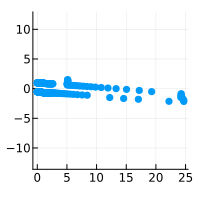

In [ ]:
t = 1_050
# -----------------
mypl = plot(size=(200,200), aspect_ratio=:equal, legend=nothing)
scatter!(_ys_inf[t], markerstrokewidth=0)

In [ ]:

zs_ = CuArray(stack([_zs[t]]))
as_ = CuArray(_as);

w           = 20
sig         = 0.1
outlier     = 0.1
outlier_vol = 100.

ys_tilde_1d_, ws_tilde_1d_ = get_1d_tilde_cu(zs_, as_, w, sig, wrap=false);
log_p, pointwise = smc_1d_logpdf(zs_, ys_tilde_1d_, ws_tilde_1d_, sig, outlier, outlier_vol; return_pointwise=true);

println(size(ys_tilde_1d_), size(ws_tilde_1d_))

zs  = repeat(range(0.,10.,100), 1, 361)
zs_ = CuArray(zs)
log_p, ptw= smc_1d_logpdf(zs_, ys_tilde_1d_, ws_tilde_1d_, sig, outlier, outlier_vol; return_pointwise=true);


# ----------------
mypl = plot(size=(500,500), aspect_ratio=:equal, legend=nothing)
scatter!(_ys_inf[t], markerstrokewidth=0)
x = Vector{Float64}[]
v = Float64[]
for i=1:2:361
    x = vcat(x, [polar_inv(z,_as[i]) for z in zs[:,i]])
    v = vcat(v, ptw[:,i])
end
perm = sortperm(v)
scatter!(x[perm], zcolor=v[perm], color=:viridis, markerstrokewidth=0, markersize=2)
mypl

In [ ]:
mu = logsumexp(ys_tilde_1d_ + ws_tilde_1d_, dims=3)[1,:,1]
mu = Array(mu)
# --------------------
mypl = plot(size=(500,500), aspect_ratio=:equal, legend=nothing)
scatter!(_ys_inf[t], c=col[1], markerstrokewidth=0, markersize=5)
scatter!(polar_inv(mu, _as), c=:magenta, markerstrokewidth=0, markersize=2)